In [1]:
import sys, os
root_dir = '\\'.join(os.getcwd().split('\\')[:-1])
sys.path.append(root_dir)

from copy import deepcopy
from functools import reduce

from buildingBlocks.Synthesis import Chain
from buildingBlocks.Synthesis.Synthesizer import Synthesizer
from buildingBlocks.default.Tokens import Constant, Sin, Product, Imp, Power, ImpComplex
from buildingBlocks.Globals.GlobalEntities import set_constants, get_full_constant
from buildingBlocks.default.EvolutionEntities import Equation
from buildingBlocks.default.EvolutionEntities import PopulationOfEquations

from buildingBlocks.Globals.supplementary.FrequencyProcessor import FrequencyProcessor4TimeSeries as fp
import buildingBlocks.Globals.GlobalEntities as Bg
import buildingBlocks.Builder.OperatorsBuilder as Ob
from load_data import get_data

from moea_dd.src.moeadd import *
from moea_dd.src.moeadd_supplementary import *
from copy import deepcopy


import moea_dd.forMoeadd.entities.EvolutionaryEntities as Ee
import moea_dd.forMoeadd.entities.Objectives as Objs

import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter

## Set tokens from which algorithm will be built model-expression
Constant token is the target that will be approximated by other tokens
ImpComplex is a set of splitted single pulses obtained from periodic impulse

In [2]:
token1 = Constant(val=None, name_='target', mandatory=1)
token2 = Sin(optimize_id=1, name_='Sin')
token3 = Imp(optimize_id=1, name_='Imp')
token4 = Power(optimize_id=2, name_='Power')

pattern = Imp(optimize_id=1)
impComplex_token = ImpComplex(pattern=pattern, optimize_id=3)

## Choose dataset
There are 3 datasets of series with different structure. Good meta parameters (build_settings) of the algorithm are selected for each of them.

### Time series with strong seasonality

In [3]:
data = get_data(0)
build_settings = {
    'mutation': {
        'simple': dict(intensive=1, increase_prob=1),
        'complex': dict(prob=0., threshold=0.1, complex_token=impComplex_token)
    },
    'crossover': {
        'simple': dict(intensive=1, increase_prob=0.3)
    },
    'tokens': [token1, token2, token3, token4],
    'population': {
        'size': 10
    }
}

### Time series without seasonality

In [ ]:
i = 2 #3
data = get_data(i)
build_settings = {
    'mutation': {
        'simple': dict(intensive=1, increase_prob=1),
        'complex': dict(prob=0.5, threshold=0.5, complex_token=impComplex_token)
    },
    'crossover': {
        'simple': dict(intensive=1, increase_prob=0.3)
    },
    'tokens': [token1, token3],
    'population': {
        'size': 10
    }
}


## Get target and grid on which target will be approximated

In [4]:
grid = data['grid']
target = data['target']
target -= target.mean()

set_constants(target=target)


## Confirm build_settings and set info about individual into evolutionary operators
max_tokens is reqularization parameter, without it model overfits

In [5]:
individ = Equation(max_tokens=10)
Ob.set_operators(grid, individ, build_settings)

# Choose type of algorithm
Evaluate only one of the next two cells.

## Single-objective optimization
optimizing only approximated quality of the model

In [6]:
population = PopulationOfEquations(iterations=2)
time = perf_counter()
population.evolutionary()
time = perf_counter() - time

inds = population.structure
idxsort = np.argsort(list(map(lambda x: x.fitness, inds)))
inds = [inds[i] for i in idxsort]
time

0/2

1/2



26.5435176

## Multi-objective optimization
This is an add-on to the previous algorithm, additionaly optimizing model complexity (number of tokens in model). Has additional multi_build_settings.

In [ ]:
multi_build_settings = {
    'weights_num': 5,
    "pop_size": 20,
    "epochs": 5
}

multi_individ = Ee.MoeaddIndividTS(x=individ, obj_funs=[Objs.objective1, Objs.objective2])
pop_constr = Ee.PopulationConstructor(pattern=multi_individ)

optimizer = moeadd_optimizer(pop_constructor=pop_constr,
                             optimized_functionals=[Objs.objective1, Objs.objective2],
                             solution_params=None,
                             delta=1 / 50.,
                             neighbors_number=5,
                             weights_num=multi_build_settings['weights_num'],
                             pop_size=multi_build_settings['pop_size'])


operator = Ee.EvolutionaryOperator()
optimizer.set_evolutionary(operator=operator)

optimizer.pass_best_objectives(0, 0)

def simple_selector(sorted_neighbors, number_of_neighbors=4):
    return sorted_neighbors[:number_of_neighbors]


optimizer.optimize(neighborhood_selector=simple_selector, delta=0.95,
                   neighborhood_selector_params=(4,), epochs=multi_build_settings['epochs'], PBI_penalty=0.75)

inds = list(map(lambda x: x.vals, optimizer.pareto_levels.levels[0]))
idxsort = np.argsort(list(map(lambda x: x.fitness, inds)))
inds = [inds[i] for i in idxsort]

## Visualize Pareto-front (for multi-objective optimization)

In [ ]:
prec = []
length = []

for idx, ind in enumerate(inds):
    prec.append(ind.fitness)
    length.append(len(ind.structure))
plt.plot(length[1:], prec[1:], '-o', color='brown')
plt.title('Pareto frontier')
plt.ylabel('Model quality')
plt.xlabel('Model complexity')

## Choose one model from proposed individuals
They are sorted by their quality (the first objective)

In [7]:
n = 0
ind = deepcopy(inds[n])
print(ind.formula(), ind.fitness)

residuals = ind.value(grid)
model = target + residuals

model -= model.mean()
residuals -= residuals.mean()

1.0target+0.43Imp(0.11t + 0.08pi)+0.24Imp(39.83t + 0.06pi)+0.12(t**0.01) 0.19295370174826953


# Generate synthetics based on the model
Use parameters threshold_value and threshold_gaps (see sklearn.cluster.AgglomerativeClustering) to control stochasticity of synthetics (only for weakly seasonal time series), control amplitude noise of synthetic by adding custom residuals (np.array with realization of a random variable (any length, preferably more))

In [8]:
tmp_ind = deepcopy(ind)

synth_settings = {
    "threshold_value": 2,
    "threshold_gaps": 0.5,
    "residuals": residuals # or None
}


split_imps= {
            'make': False,
            'min_ampl': 0.05,
            'max_freq': float('inf')
}

clusterer_value = Chain.ClustererPulses(
    distance_threshold=synth_settings["threshold_value"],
    params=dict(grid=grid)
)
clusterer_gaps = Chain.ClustererGaps(distance_threshold=synth_settings["threshold_gaps"])
coder = Chain.Coder2(
    clusterer_value=clusterer_value,
    clusterer_gaps=clusterer_gaps,
    individ=tmp_ind,
    params=dict(grid=grid)
)
mc = Chain.BayesianChain()

syc = Synthesizer(
    individ=tmp_ind, 
    grid=grid, 
    coder=coder, 
    markov_chain=mc,
    residuals=synth_settings['residuals'],
    split_imps=split_imps
)
# print(tmp_ind.formula())

syc.fit()



# Having fitted generative model - start generate

In [9]:
target_spec = fp.fft(grid, target)
model_spec = fp.fft(grid, model)

dt = grid[1] - grid[0]
new_grid = np.arange(grid.min(), 1.2 * grid.max(), dt)

## Generate synthetic sample


Every evaluation of this cell gives different results

In [10]:
synthetic = syc.predict(new_grid)[:len(grid)]
synthetic -= synthetic.mean()
synthetic_spec = fp.fft(grid, synthetic)
synthetic_quality = (np.var((np.abs(target_spec[1]) - np.abs(synthetic_spec[1])))
                 / np.var(np.abs(target_spec[1])))/(np.var(target - synthetic) / np.var(target))

## See what you obtain

### In the time domain

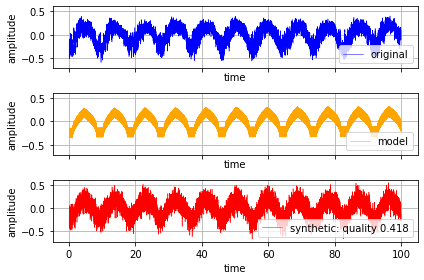

In [11]:
fig = plt.figure('orig and synthetic')
axs = fig.subplots(3, 1, sharex=True, sharey=True)
ts = [target, model]
# ax = [None for _ in range(3)]
labels = ['original', 'model', 'synthetic']
colors = ['blue', 'orange', 'green']

for i in range(3):
    if i == 2:
        axs[i].plot(grid, synthetic, color='red', linewidth=0.5, label='synthetic: quality {}'.format(round(synthetic_quality, 3)))
    else:
        axs[i].plot(grid, ts[i], label=labels[i], color=colors[i], linewidth=0.5)
    axs[i].grid(True)
    axs[i].set_xlabel('time')
    axs[i].set_ylabel('amplitude')
    axs[i].legend()

fig.align_labels(axs)
fig.tight_layout()

### Spectra

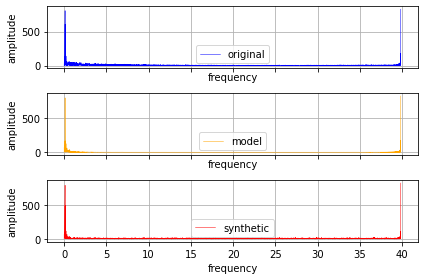

In [12]:
fig_sp = plt.figure('spectra')
axs = fig_sp.subplots(3, 1, sharex=True, sharey=True)

specs = [target_spec, model_spec]

for i in range(3):
    if i == 2:
        axs[i].plot(synthetic_spec[0], np.abs(synthetic_spec[1]), label=labels[i], color='red', linewidth=0.5)
    else:
        axs[i].plot(specs[i][0], np.abs(specs[i][1]), label=labels[i], color=colors[i], linewidth=0.5)
    axs[i].grid(True)
    axs[i].set_xlabel('frequency')
    axs[i].set_ylabel('amplitude')
    axs[i].legend()
fig_sp.align_labels(axs)
fig_sp.tight_layout()

plt.show()